# EfficientNet
- The architecture of EfficientNet is based on a concept called "compound scaling." It means that the model is scaled up or down in a balanced way across different dimensions, such as depth, width, and resolution. This scaling ensures that the model is efficient in terms of both accuracy and resource utilization.

- Depth of the model refers to the number of layers. EfficientNet increases the depth by stacking more layers, allowing the model to learn complex patterns and features from the input images.

- Width refers to the number of channels in each layer. EfficientNet increases the width by expanding the number of channels, which helps the model capture more diverse information and make better predictions.

- Resolution is the size of the input images. EfficientNet adjusts the resolution based on a predefined scaling factor, which allows the model to handle images of different sizes efficiently.

## Abstract
Systematic balancing of model scaling that includes:
- Network depth: No. of Layers
- Network width: No. of Channels
- Resolution: Input Image shape

## Compound Scaling Method
Here,
- depth: d = alpha^phi
- width: w = beta^phi
- resolution: r = gamma^phi

And, increase in **phi**, increases the computational resource consumption by **2^phi**.

1. EfficientNet B0
- `Fix phi=1`, suct that `alpha x beta^2 x gamma^2 = 2`,so **alpha=1.2, beta=1.1 and gamma=1.15.**

2. EfficientNet B1 to EfficientNet B7
- `Fix alpha, beta and gamma` and scale baseline with `different phi`.


# EfficientNet Architecture

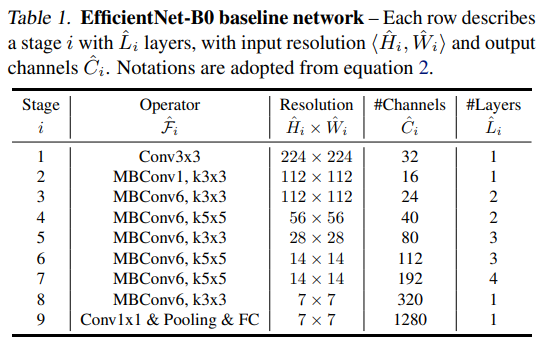

In [8]:
# Imports
import torch
import torch.nn as nn
from math import ceil

In [9]:
# Specifying base model for MBConv
base_model = [
    # Expand_ratio, channels, repeats, stride, kernel_size
    [1,16,1,1,3],
    [6,24,2,2,3],
    [6,40,2,2,5],
    [6,80,3,2,3],
    [6,112,3,1,5],
    [6,192,4,2,5],
    [6,320,1,1,3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0":(0, 224, 0.2),
    "b1":(0.5, 240, 0.2),
    "b2":(1, 260, 0.3),
    "b3":(2, 300, 0.3),
    "b4":(3, 380, 0.4),
    "b5":(4, 456, 0.4),
    "b6":(5, 528, 0.5),
    "b7":(6, 600, 0.5),
}

The formula for Hard Swish is as follows:

HardSwish(x) = x * ReLU6(x + 3) / 6



In [10]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
    super(CNNBlock, self).__init__()

    self.cnn = nn.Conv2d(in_channels,
                         out_channels,
                         kernel_size,
                         stride,
                         padding,
                         groups=groups, # 'groups' parameter for depth-wise convolution i.e for each channel independently
                         bias=False)

    self.bn = nn.BatchNorm2d(out_channels)
    self.hard_swish = nn.Hardswish()

  def forward(self, x):
    return self.hard_swish(self.bn(self.cnn(x)))

**Note:** `groups` controls the connections between inputs and outputs. `in_channels` and `out_channels` must both be divisible by groups. For example,

- At groups=1, all inputs are convolved to all outputs.

- At groups=2, the operation becomes equivalent to having two conv layers side by side, each seeing half the input channels and producing half the output channels, and both subsequently concatenated.

- At groups= in_channels, each input channel is convolved with its own set of filters

In [11]:
class SqueezeExcitation(nn.Module):
  def __init__(self, in_channels, reduced_dim):
    super(SqueezeExcitation, self).__init__()

    self.se = nn.Sequential(nn.AdaptiveAvgPool2d(1), # CxHxW --> Cx1x1
                            nn.Conv2d(in_channels, reduced_dim, kernel_size=1),
                            nn.Hardswish(),
                            nn.Conv2d(reduced_dim, in_channels, kernel_size=1), # Brings back the original channels
                            nn.Sigmoid()) # Reduce the channels

  def forward(self, x):
    return x * self.se(x) # Each channel is multiplied to the value/attention scores which determines the priority

In [12]:
class InvertedResidualBlock(nn.Module):
  def __init__(self,
               in_channels,
               out_channels,
               kernel_size,
               stride,
               padding,
               expand_ratio, # Expands i/p to higher number of channels --> depth-wise conv --> back to same shape of i/p
               reduction=4,# For squeeze excitation
               dropout_index=None
               ):
    super(InvertedResidualBlock, self).__init__()

    self.use_residual = in_channels == out_channels and stride == 1 # Use residual connection if condition satisfies
    self.dropout_index = dropout_index

    hidden_dim = in_channels * expand_ratio
    self.expand = in_channels != hidden_dim # In same stage -- no expansion , when switching stages -- expansion

    reduced_dim = int(in_channels / reduction)

    if self.expand:
      self.expand_conv = CNNBlock(
          in_channels, hidden_dim, kernel_size=1, stride=1, padding=0,
      )

    self.conv = nn.Sequential(
        CNNBlock(
            hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
        ),
        SqueezeExcitation(hidden_dim, reduced_dim),
        nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels))

  # For dropout
  def dropout_rate(self, x):
    if not self.training:
      return x

    dropout_rates = [0.025, 0.05, 0.075, 0.0875, 0.1125, 0.125, 0.15, 0.1625, 0.175]

    dropout_rate = dropout_rates[self.dropout_index] # Get dropout rate from the list
    dropout_layer = nn.Dropout(dropout_rate) # Create dropout layer
    return dropout_layer(x)


  def forward(self, inputs):
    x = self.expand_conv(inputs) if self.expand else inputs

    if self.use_residual:
      return self.dropout_rate(self.conv(x)) + inputs
    else:
      return self.conv(x)

In [13]:
class EfficientNet(nn.Module):
  def __init__(self, version, num_classes):
    super(EfficientNet, self).__init__()

    width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
    last_channels = ceil(1280 * width_factor)

    self.pool = nn.AdaptiveAvgPool2d(1)

    self.features = self.create_features(width_factor, depth_factor, last_channels)
    self.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(last_channels, num_classes),
    )

  def calculate_factors(self, version, alpha=1.2, beta=1.1):
    phi, resolution, drop_rate = phi_values[version]
    depth_factor = alpha ** phi
    width_factor = beta ** phi
    return width_factor, depth_factor, drop_rate

  def create_features(self, width_factor, depth_factor, last_channels):
    channels = int(32 * width_factor) # From initial conv layer, there are 32 channels which increases between stages
    features = [CNNBlock(3, channels, 3, stride=2, padding=1)] # Since image has in_channels = 3
    in_channels = channels # Update in_channels for next layer

    dropout_index = 0  # Initialize the dropout index

    # Now iterate through all stages of base model
    for expand_ratio, channels, repeats, stride, kernel_size in base_model:

      # Since during Squeeze Excitation, we reduce the channels by 4, so making sure the out_channels is divisible by 4
      out_channels = 4 * ceil(int(channels * width_factor) / 4)

      layers_repeats = ceil(repeats * depth_factor)

      for layer in range(layers_repeats):
        if layer != 0: # Apply dropout
          features.append(
              InvertedResidualBlock(
                  in_channels,
                  out_channels,
                  expand_ratio = expand_ratio,
                  stride = stride if layer == 0 else 1,
                  kernel_size = kernel_size,
                  padding = kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                  dropout_index = dropout_index
              )
          )
          dropout_index += dropout_index # Increment the dropout index
        else:
          features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride=stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,
                    )
                )
        in_channels = out_channels


    features.append(
        CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
    )

    return nn.Sequential(*features)

  def forward(self, x):
    x = self.pool(self.features(x))
    return self.classifier(x.view(x.shape[0], -1))


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
version = 'b0'

phi, resolution, drop_rate = phi_values[version]
num_images, num_classes = 4, 3

# Fake image for test --> so random generation
x = torch.randn((num_images, 3, resolution, resolution)).to(device)

# Instantiate the model
model = EfficientNet(
    version = version,
    num_classes=num_classes,
).to(device)

# Test
model(x).shape

torch.Size([4, 3])

In [15]:
# Generate the summary of the model
from torchsummary import summary

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
         Hardswish-3         [-1, 32, 112, 112]               0
          CNNBlock-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
         Hardswish-7         [-1, 32, 112, 112]               0
          CNNBlock-8         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             264
        Hardswish-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
SqueezeExcitation-14         [-1, 32, 1

In [16]:
# Save the trained model
save_path = "EfficientNetV1_untrained.pth"
torch.save(model.state_dict(), save_path)

print("Trained model saved at:", save_path)

Trained model saved at: EfficientNetV1_untrained.pth


# Load CIFAR-10 dataset

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to apply to the CIFAR-10 data
transform = transforms.Compose([transforms.Resize((224,224)), #<-- Resize for EfficientNet input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load train and test data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 49738672.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [18]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [19]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [20]:
# The classes in the dataset
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([3, 224, 224]) 0
Label:  airplane (0)


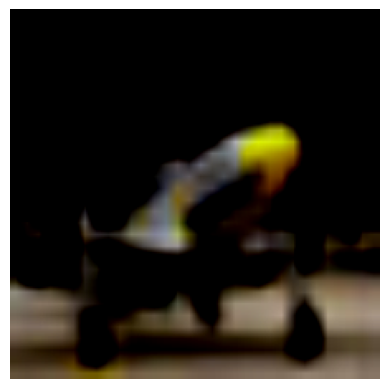

In [21]:
# Let's visualize the 12345th image in the train_dataset
feature, label = train_dataset[12344]
print(feature.shape, label)

import matplotlib.pyplot as plt

# Permute the image tensor from 3x224x224 to 224x224x3
image = torch.permute(feature, (1, 2, 0))

# Display the image
plt.imshow(image)
print('Label: ', train_dataset.classes[label], "("+str(label)+")")
plt.axis('off') # To remove axis label
plt.show()

# Filtered Dataset

In [22]:
# Filter images from specific labels
desired_labels = [0, 1, 2]  # Airplane, Automobile, Bird
filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in desired_labels]
filtered_dataset = torch.utils.data.Subset(train_dataset, filtered_indices)

# Save the filtered dataset locally
save_path = "./filtered_dataset.pth"
torch.save(filtered_dataset, save_path)

print("Filtered dataset saved at:", save_path)

Filtered dataset saved at: ./filtered_dataset.pth


In [23]:
# Random split filtered dataset
from torch.utils.data import random_split

# Define the proportions for train and test split
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the sizes for train and test datasets
train_size = int(train_ratio * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size

# Split the dataset into train and test subsets
train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

# Verify the sizes of the train and test datasets
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 12000
Test dataset size: 3000


# DataLoader for Train-Test Dataset

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [25]:
# Example from train_loader
train_iterate = iter(train_loader)
features, labels = next(train_iterate)
features.shape

torch.Size([8, 3, 224, 224])

In [26]:
labels

tensor([0, 1, 2, 2, 0, 2, 0, 0])

# Train on filtered dataset

In [27]:
# Instantiate the model
model_train = EfficientNet(
    version = 'b0', # For EfficientNet B0
    num_classes=3,
).to(device)

In [28]:
# Compile the model
# Define the optimizer
optimizer = torch.optim.Adam(model_train.parameters(), lr=0.0001) # Decrease the lr, because batch normalization

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [29]:
from tqdm import tqdm
import time

num_epochs = 10 # For less computation

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model_train.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Update running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1) # the maximum value and the index of that maximum value along dimension 1
        running_corrects += torch.sum(preds == labels.data) # labels.data gives access to underlying labels tensor

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Calculate epoch loss and accuracy for training data
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

Epochs:  10%|█         | 1/10 [01:55<17:18, 115.38s/it]

Epoch 1 completed in 115.36 seconds
Epoch [1/10], Train Loss: 0.6967, Train Accuracy: 0.7017


Epochs:  20%|██        | 2/10 [03:45<14:56, 112.12s/it]

Epoch 2 completed in 109.83 seconds
Epoch [2/10], Train Loss: 0.4862, Train Accuracy: 0.8056


Epochs:  30%|███       | 3/10 [05:33<12:51, 110.24s/it]

Epoch 3 completed in 107.98 seconds
Epoch [3/10], Train Loss: 0.3747, Train Accuracy: 0.8547


Epochs:  40%|████      | 4/10 [07:20<10:54, 109.03s/it]

Epoch 4 completed in 107.17 seconds
Epoch [4/10], Train Loss: 0.2747, Train Accuracy: 0.8965


Epochs:  50%|█████     | 5/10 [09:06<08:59, 107.81s/it]

Epoch 5 completed in 105.62 seconds
Epoch [5/10], Train Loss: 0.2126, Train Accuracy: 0.9183


Epochs:  60%|██████    | 6/10 [10:51<07:08, 107.15s/it]

Epoch 6 completed in 105.85 seconds
Epoch [6/10], Train Loss: 0.1642, Train Accuracy: 0.9399


Epochs:  70%|███████   | 7/10 [12:38<05:20, 106.86s/it]

Epoch 7 completed in 106.26 seconds
Epoch [7/10], Train Loss: 0.1309, Train Accuracy: 0.9534


Epochs:  80%|████████  | 8/10 [14:24<03:33, 106.72s/it]

Epoch 8 completed in 106.41 seconds
Epoch [8/10], Train Loss: 0.1072, Train Accuracy: 0.9608


Epochs:  90%|█████████ | 9/10 [16:09<01:46, 106.24s/it]

Epoch 9 completed in 105.18 seconds
Epoch [9/10], Train Loss: 0.0924, Train Accuracy: 0.9681


Epochs: 100%|██████████| 10/10 [17:55<00:00, 107.60s/it]

Epoch 10 completed in 106.17 seconds
Epoch [10/10], Train Loss: 0.0720, Train Accuracy: 0.9748


In [30]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    model_train.eval() # Set the model to evaluation mode

    for inputs, labels in test_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.67%


In [31]:
# Save the trained model
save_path = "EfficientNetV1.pth"
torch.save(model_train.state_dict(), save_path)

print("Trained model saved at:", save_path)

Trained model saved at: EfficientNetV1.pth


# Inference

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EfficientNet(version = 'b0', num_classes=3)
    model.load_state_dict(torch.load("/content/EfficientNetV1.pth")) # Load the model
    model.eval()
    model = model.to(device)

    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    input_image = transform(image).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image)

    _, predicted = torch.max(output.data, 1)

    # Get the predicted class probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]

    # Get the predicted class label
    predicted_class = torch.argmax(probabilities).item()

    return probabilities, predicted_class

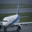

Predicted class: airplane
Probability: 0.9992367029190063


In [33]:
# Test on airplane
image_path = "/content/airplane.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

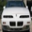

Predicted class: automobile
Probability: 0.9990686774253845


In [34]:
# Test on automobile
image_path = "/content/automobile.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

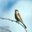

Predicted class: bird
Probability: 0.999715268611908


In [35]:
# Test on bird
image_path = "/content/bird.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())